In [11]:
#import necessary packages
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint


In [12]:
#checking version bc im trying to get tf-gpu to work
print(tf.__version__)

2.5.0


In [13]:
#also for tf-gpu
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [14]:

#same as above
#import keras

print(keras.__version__)

2.5.0


In [15]:
#only showing cpu; cant get gpu to work :P
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4738269101619243688
]


In [16]:
#these are all the classes; I got this code from kaggle
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
#defining the size of the images when they are shaped using opencv. I will use this to change the size
IMAGE_SIZE = (150, 150)



In [7]:
#Easy model loading fcn from the same kaggle
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../../../../archive/seg_train/seg_train', '../../../../archive/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
#get the images and labels
(train_images, train_labels), (test_images, test_labels) = load_data()

  4%|▍         | 85/2191 [00:00<00:02, 842.51it/s]

Loading ../../../../archive/seg_train/seg_train


 47%|████▋     | 206/437 [00:00<00:00, 1023.37it/s]

Loading ../../../../archive/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 948.00it/s]


In [9]:
#how many of each?
train_labels.shape
test_labels.shape


(3000,)

In [10]:
#reshape the images, but i won't shange the size yet also set to float to be sure and normalize
train_images = train_images.reshape((-1,150,150,3)).astype('float32') / 255.0
test_images = test_images.reshape((-1,150,150,3)).astype('float32') / 255.0

In [11]:
#make a df for easy visual
train_dist = pd.DataFrame(train_labels,columns=['labels'])

In [12]:
#looking at classes
class_names

['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']

In [13]:
#test df
test_dist = pd.DataFrame(test_labels,columns=['labels'])

In [14]:
#this is a df containing all labels that ill use for a hist
train_dist

,labels
0,3
1,3
2,3
3,3
4,3
...,...
14029,1
14030,1
14031,1
14032,1


In [15]:
#im mapping the labels to words so it is human readable
class_map = {0:'mountain',1:'street',2:'glacier',3:'buildings',4:'sea',5:'forest'}
train_dist['labels'] = train_dist['labels'].map(class_map)
test_dist['labels'] = test_dist['labels'].map(class_map)


In [16]:
import seaborn as sns

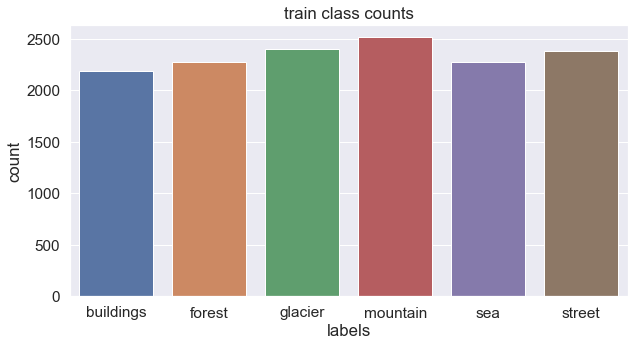

In [17]:
#make hists showing class balance for both train and test
sets = [train_dist,test_dist]

fig, ax = plt.subplots(figsize=(10,5))

ax = sns.countplot(x='labels',data=sets[0])
ax = plt.title('train class counts')

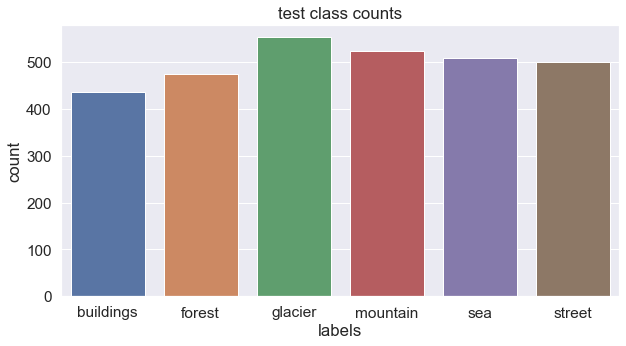

In [18]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.countplot(x='labels',data=sets[1])
ax = plt.title('test class counts')

How well does it perform on each class. Which ones is it best at? are there any two it can't diff btwn. Is there a way to see in an img what the network does btwn the layers. i.e. shallow net import vs deeper net. Using lime img class with keras. Obj in img that it need to focus on. Maybe PCA for color in theory to get one PC for color or greyscale it. Or PCA for reducing dimesionality.

Deployment, demo maybe with LIME after to show btwn layers. predetermined image to model and lime to maintain comprehensibility for viewers. 

color compression ideas:

PCA
greyscale
something else?


How to verify that adding layers helps the model?

how fast it converges
how many epochs it takes with a set batch size
loss at stop?
difference in train and val metrics

combine some labels to turn into a binary classification problem. Then use those outputs to classify wihin those groups

In [19]:
from tensorflow.keras.preprocessing.image import array_to_img

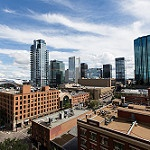

In [20]:
#playing around with viewing images
array_to_img(train_images[1])

In [21]:
#this splits each image into three. One for each color so each (150,150,3) array becomes three (150,150,1) arrays
blue,green,red = cv2.split(train_images[1]) 

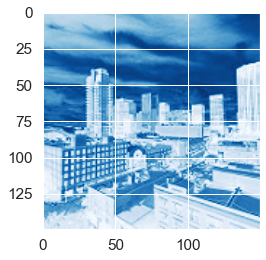

In [22]:
#view each one. color isn't there. I added to make visual better
plt.imshow(blue,interpolation='bilinear',cmap='Blues')

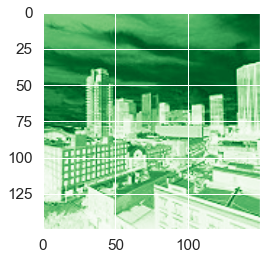

In [23]:
plt.imshow(green,interpolation='bilinear',cmap='Greens')

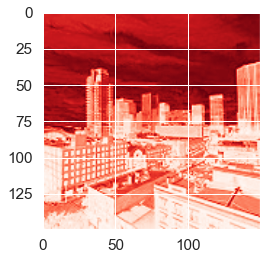

In [24]:
plt.imshow(red,interpolation='bilinear',cmap='Reds')

In [25]:
from sklearn.decomposition import PCA

In [26]:
#this is one way of compressing the images
#it decomposes each color array for each picture and then reconstructs it
pca = PCA(110)

In [27]:
#Applying to red channel and then applying inverse transform to transformed array.
red_transformed = pca.fit_transform(red)
red_inverted = pca.inverse_transform(red_transformed)
 
#Applying to Green channel and then applying inverse transform to transformed array.
green_transformed = pca.fit_transform(green)
green_inverted = pca.inverse_transform(green_transformed)
 
#Applying to Blue channel and then applying inverse transform to transformed array.
blue_transformed = pca.fit_transform(blue)
blue_inverted = pca.inverse_transform(blue_transformed)

In [28]:
img_compressed = (np.dstack((red_inverted, red_inverted, red_inverted))).astype(np.uint8)

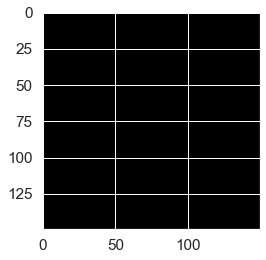

In [29]:
#imshow doesn't work bc the image arrays are normalized
plt.imshow(img_compressed)

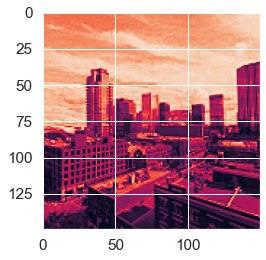

In [30]:
#here is one layer
plt.imshow(red_inverted)

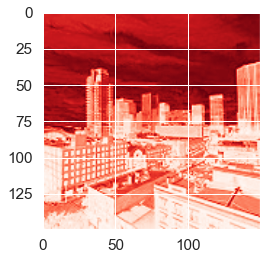

In [31]:
#red after being reconstructed from 20 PCs
plt.imshow(red,interpolation='bilinear',cmap='Reds')

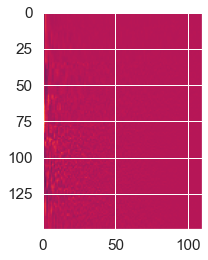

In [32]:
plt.imshow(red_transformed)

In [33]:
#shaping to feed into an dense NN, but i decided to go straight to CNN so this isn't needed
train_img_reshaped = train_images.reshape(train_images.shape[0],-1)
test_img_reshaped = test_images.reshape(test_images.shape[0],-1)

In [34]:
train_img_reshaped[1].shape

(67500,)

In [35]:
train_labels.shape

(14034,)

In [44]:
from tensorflow.keras import models, layers

In [45]:
#first model
model = models.Sequential()

In [46]:
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(6,activation='softmax'))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 350464)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               44859520  
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 44,862,086
Trainable params: 44,862,086
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [49]:
#added checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint("../../../../Models/bbaseline_model.h5", save_best_only=True)


In [50]:
history = model.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=10,
                    validation_data=(test_images,test_labels),
                    callbacks=[checkpoint])

Epoch 1/10
878/878 [==============================] - 210s 239ms/step - loss: 1.0536 - acc: 0.6618 - val_loss: 0.8162 - val_acc: 0.7173
Epoch 2/10
878/878 [==============================] - 208s 237ms/step - loss: 0.4945 - acc: 0.8298 - val_loss: 0.7372 - val_acc: 0.7447
Epoch 3/10
878/878 [==============================] - 209s 238ms/step - loss: 0.2372 - acc: 0.9236 - val_loss: 1.0011 - val_acc: 0.7003
Epoch 4/10
878/878 [==============================] - 210s 239ms/step - loss: 0.1155 - acc: 0.9670 - val_loss: 1.1965 - val_acc: 0.7197
Epoch 5/10
878/878 [==============================] - 212s 242ms/step - loss: 0.0723 - acc: 0.9802 - val_loss: 1.2218 - val_acc: 0.6913
Epoch 6/10
878/878 [==============================] - 218s 249ms/step - loss: 0.0764 - acc: 0.9788 - val_loss: 1.2896 - val_acc: 0.6850
Epoch 7/10
878/878 [==============================] - 211s 240ms/step - loss: 0.0687 - acc: 0.9806 - val_loss: 2.1269 - val_acc: 0.6800
Epoch 8/10
878/878 [============================

In [51]:
model.evaluate(train_images,train_labels)

439/439 [==============================] - 33s 75ms/step - loss: 0.0264 - acc: 0.9945


[0.026394927874207497, 0.9945133328437805]

In [52]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

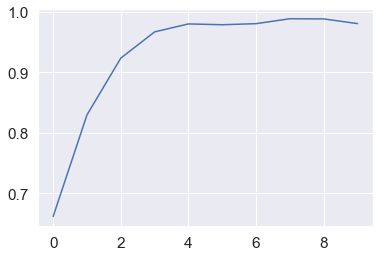

In [54]:
plt.plot(range(0,10),history.history['acc'])

Text(19.25, 0.5, 'Accuracy')

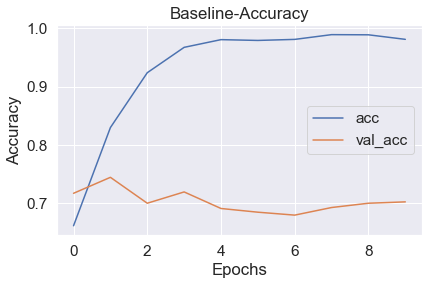

In [59]:
#major overfitting
metrics = ['acc','val_acc']
for metric in metrics:
    plt.plot(history.history[metric], label=metric)
plt.title('Baseline-Accuracy')
plt.legend()
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(19.25, 0.5, 'Loss')

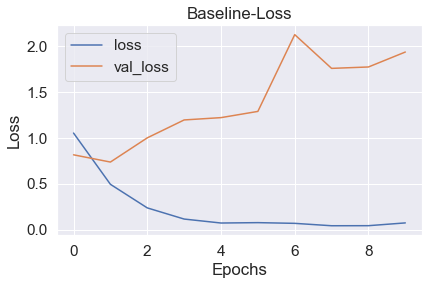

In [60]:
metrics = ['loss','val_loss']
for metric in metrics:
    plt.plot(history.history[metric], label=metric)
plt.title('Baseline-Loss')

plt.legend()
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
#trying to add lime
#will come back later bc error
model = keras.models.load_model("b.h5")

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

earlystop = keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
)

In [ ]:
history = model.fit(train_images,train_labels,batch_size=16,epochs=25,validation_data=(test_images,test_labels),callbacks=[earlystop])

In [ ]:
import lime

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
import random

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=1)

In [ ]:
explanation = explainer.explain_instance(train_images[10], model.predict)
plt.imshow(train_images[10])
temp, mask = explanation.get_image_and_mask(model.predict(train_images[10].reshape((1,28,28,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

In [ ]:
#error: expects double not float32